<a href="https://colab.research.google.com/github/IgorStellet/Casual_Works/blob/main/FP1_2025_2_T4_IgorStellet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Igor Almeida da Silva Gouvêa Stellet

# Tarefa 4 - Parte 1

## Functions and libraries

In [ ]:
#Libraries that will be used
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import imageio
import scipy.stats
import scipy.optimize
from scipy.interpolate import CubicSpline, interp1d
import numpy as np
from IPython.display import HTML
from google.colab import files
from IPython.display import Image
from math import comb
import pandas as pd

In [ ]:
# Functions setup for Parrondo's paradox (Classic)

#1)-------------- Losing Game A ----------------

def gameA(budget: float, pA1: float=0.5, eps: float=0.005) -> float:
  """
  One turn of Game A.

  Parameters
  ----------
    budget : int | float
        Current balance (capital).
    pA1 : float, default 0.5
        Base winning probability of coin A.
    eps : float, default 0.005
        Bias subtracted from the base probability (p = pA1 - eps).

  Returns
  -------
  float
    Updated budget after one turn.
  """
  prob = pA1 - eps
  budget = budget + 1 if (np.random.random() < prob) else budget - 1

  return budget

#2)-------------- Losing Game B ----------------
def gameB( budget: float, M: int =3 , pB1: float=0.1, epsB1: float=0.005,
          pB2: float =0.75, epsB2: float =0.005  )-> float:
  """
  One turn of Game B. The coin depends on budget mod M

  Parameters
  ----------
    budget : int | float
        Current budget (capital).
    M : int, default 3
        Modulus controlling which coin is used.
    pB1 : float, default 0.1
        Base winning probability of coin B1 (used when budget % M == 0).
    epsB1 : float, default 0.005
        Bias subtracted from pB1 (p1 = pB1 - epsB1).
    pB2 : float, default 0.75
        Base winning probability of coin B2 (otherwise).
    epsB2 : float, default 0.005
        Bias subtracted from pB2 (p2 = pB2 - epsB2).

  Returns
  -------
    float
        Updated budget after one turn.
  """
  prob1 = pB1 - epsB1
  prob2 = pB2 - epsB2

  # Choosing coins
  if budget % M == 0: # Coin B1 (high chance to lose)
      budget = budget + 1 if (np.random.random() < prob1) else budget - 1

  else:   # Coin B2 (higher chance to win)
      budget = budget + 1 if (np.random.random() < prob2) else budget - 1

  return budget


#3)-------------- Game AB together ----------------

def gameAB(budget: float=0,
           strategy=("A","A","B","B"),
           steps: int=100, sample: int = 50_000,
           pA1: float = 1/2, epsA1: float = 0.005,
           M: int =3,
           pB1: float=0.1, epsB1: float =0.005,
           pB2: float=0.75, epsB2: float=0.005,
           return_path: bool = False):
    """
    Play a sequence of A/B games for many trials and (optionally) return the average path.

    Parameters
    ----------
    budget : int | float, default 0
        Initial budget (capital).
    strategy : {"A","B","random", None} | sequence of "A"/"B", default ("A","A","B","B")
        - "A" or "B": always play that game;
        - sequence (e.g., ("A","A","B","B")): cycle through it;
        - "random" or None: choose A/B uniformly at each step.
    steps : int, default 100
        Number of turns per trial (games played).
    sample : int, default 50_000
        Number of independent trials to average (Monte Carlo).
    pA1, epsA1, M, pB1, epsB1, pB2, epsB2 : floats/ints
        Same meanings as in Game A and Game B.
    return_path : bool, default False
        If True, also return the mean capital after each step (length = steps+1).

    Returns
    -------
    float
        Final mean budget after 'steps' games.
    (float, np.ndarray) if return_path=True
        Tuple of (final mean budget, mean path array).
    """
    sample = int(sample)  # In case float was passed
    mean_path = np.zeros(steps + 1, dtype=float)
    sumsq_path = np.zeros(steps+1, dtype=float)

    # helper to pick which game to play at a given step
    def pick_game(t: int):
        if strategy is None or (isinstance(strategy, str) and strategy.lower() == "random"):
            return "A" if (np.random.random() < 0.5) else "B"
        if isinstance(strategy, str):
            return strategy.upper()
        # sequence / cycle
        return strategy[t % len(strategy)]

    for _ in range(sample):
        capital = budget
        mean_path[0] += capital
        sumsq_path[0] += capital**2
        for t in range(steps):
            game = pick_game(t)
            if game == "A":
                capital = gameA(budget=capital, pA1=pA1, eps=epsA1)
            else:
                capital = gameB(budget=capital, M=M, pB1=pB1, epsB1=epsB1, pB2=pB2, epsB2=epsB2)
            mean_path[t + 1] += capital
            sumsq_path[t+1] += capital**2

    mean_path /= sample
    var_path = np.maximum(0.0, sumsq_path/sample -mean_path**2)
    std_path = np.sqrt(var_path) # standard deviation per step

    final_mean = float(mean_path[-1])
    return (final_mean, mean_path, std_path) if return_path else final_mean




## Reproducing article, results and explanations

### Game A - Only

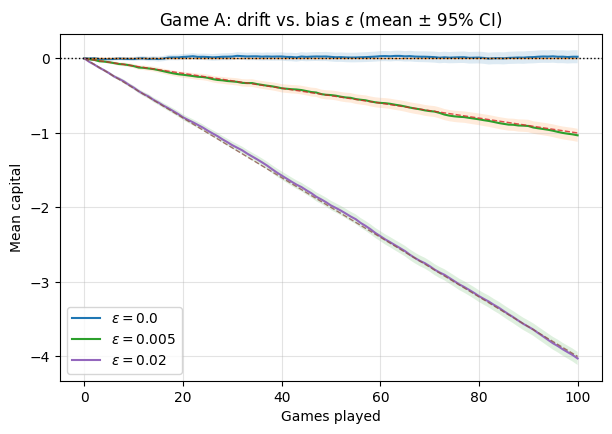

In [ ]:
# ---------- Parameters ----------
sample = 50_000   # number of trials
steps  = 100      # games per trial
budget0 = 0.0
pA1 = 0.5
eps_list = (0.0, 0.005, 0.02)

np.random.seed(42)  # reproducibility

plt.figure(figsize=(7,4.5))
x = np.arange(steps+1)

for eps in eps_list:
    # Game A only
    _, mean_A, std_A = gameAB(budget=budget0, strategy="A", steps=steps, sample=sample,
                          pA1=pA1, epsA1=eps, return_path=True)
    sem_A = std_A / np.sqrt(sample)
    # plot mean + 95% CI
    label = rf"$\epsilon={eps}$"
    plt.plot(x, mean_A, label=label)
    plt.fill_between(x, mean_A - 1.96*sem_A, mean_A + 1.96*sem_A, alpha=0.15)

    # theoretical straight line: E[C_t] = C0 + (2pA -1) t = C0 - 2\eps*t   (since pA1=1/2)
    theory = budget0 + (2*(pA1 - eps) - 1.0) * x
    plt.plot(x, theory, ls="--", lw=1, alpha=0.8)

plt.axhline(0, ls=":", lw=1, color="k")
plt.title("Game A: drift vs. bias $\\epsilon$ (mean ± 95% CI)")
plt.xlabel("Games played")
plt.ylabel("Mean capital")
plt.grid(True, alpha=0.35)
plt.legend()
plt.show()


**Explanation of the Graphic:**

Game A flips one biased coin wit $p_A= \frac{1}{2}-ϵ$. The expected increment per turn is $Δμ_A=2p_A-1=-2ϵ$. Therefore $E[C_t]≈C_0-2ϵt$: straight lines with slope $-2ϵ$. The dashed line is this theorical formula; the sahed band is the 95% error of the Monte Carlo mean. As $ϵ$ grows, the negative drift becomes steerp as expected.

We can clearly see that for $ϵ>0$ Game A is a losing game.

### Game B - Only

**A) Varying M (state dependence)**

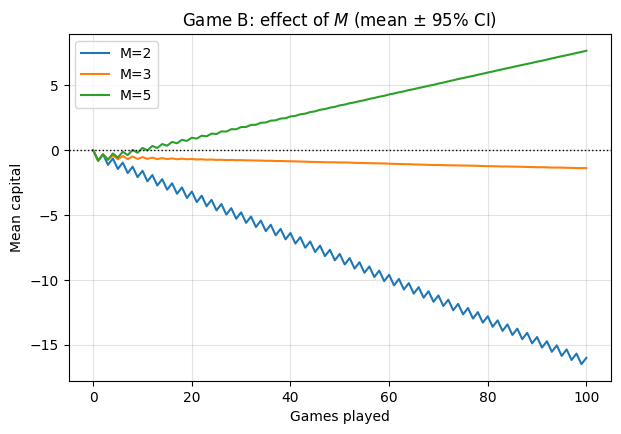

In [ ]:
# ---------- Parameters ----------
sample = 50_000
steps  = 100
budget0 = 0.0
pB1, epsB1 = 0.1, 0.005
pB2, epsB2 = 0.75, 0.005
M_list = (2, 3, 5)

np.random.seed(123)  # reproducibility

plt.figure(figsize=(7,4.5))
x = np.arange(steps+1)

for M in M_list:
    # Game B only
    _, mean_B, std_B = gameAB(budget=budget0, strategy="B", steps=steps, sample=sample,
                           M=M, pB1=pB1, epsB1=epsB1,
                           pB2=pB2, epsB2=epsB2, return_path=True)
    sem_B = std_B / np.sqrt(sample)
    plt.plot(x, mean_B, label=f"M={M}")
    plt.fill_between(x, mean_B - 1.96*sem_B, mean_B + 1.96*sem_B, alpha=0.15)

plt.axhline(0, ls=":", lw=1, color="k")
plt.title("Game B: effect of $M$ (mean ± 95% CI)")
plt.xlabel("Games played")
plt.ylabel("Mean capital")
plt.grid(True, alpha=0.35)
plt.legend()
plt.show()


**Explanation of the Graphic:**

Game B uses a *bad* coin when $C_t≡0$ (mod M) and a *good* coin otherwise; This creates a Markov chain over residues. For **M=3** (classic case in the article) the stationary distribution places extra weight on the "bad" residue, even thouht the good coin if often used. Changing M perturbs this balance and dift the expected final capital.

It's interesting to note that when M is small, bad money is used more often, causing a rapid decline in capital. On the other hand, if M is large, bad money is used less often, causing capital to increase.

It's interesting to note that when M is small, the bad coin is used more often, causing a rapid decline in capital. On the other hand, if M is large, the bad coin is used less often, causing capital to increase (M=5 in graphic).

Of course, this behavior depends on the weight of the bad coin (in this case pB1=0.1). The lower the probability of winning with the bad coin, the higher the value of M must be for B to become a winning game.

We clearly see that for M=3, we have a losing game.

**B) Varying ϵ at fixed M=3**

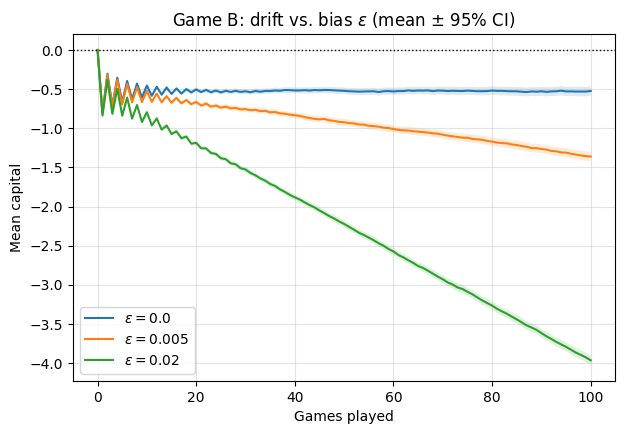

In [ ]:
# ---------- Parameters ----------
sample = 50_000
steps  = 100
budget0 = 0.0
M = 3
eps_list = (0.0, 0.005, 0.02)
pB1, pB2 = 0.1, 0.75

np.random.seed(456)

plt.figure(figsize=(7,4.5))
x = np.arange(steps+1)

for eps in eps_list:
    # Game B only
    _, mean_B, std_B = gameAB(budget=budget0, strategy="B", steps=steps, sample=sample,
                           M=M, pB1=pB1, epsB1=eps,
                           pB2=pB2, epsB2=eps, return_path=True)
    sem_B = std_B / np.sqrt(sample)
    plt.plot(x, mean_B, label=rf"$\epsilon={eps}$")
    plt.fill_between(x, mean_B - 1.96*sem_B, mean_B + 1.96*sem_B, alpha=0.15)

plt.axhline(0, ls=":", lw=1, color="k")
plt.title("Game B: drift vs. bias $\\epsilon$ (mean ± 95% CI)")
plt.xlabel("Games played")
plt.ylabel("Mean capital")
plt.grid(True, alpha=0.35)
plt.legend()
plt.show()


**Exaplanation of the Graphic:**

Increasing $ϵ$ in the both coins lowers both coin probabilities of winning, and, as expected, this streght the negative drift. But, unlike Game A, the drift stems from how often the process lands in the bad coin, not just from a fixed coin bias. We can see that in $ϵ=0$ (without bias), because unlike game A, in that case game B is stil a losing game.

### Reproducing Fig. 1B (A,B, Periodic AABB, Random) and others

**Fig 1.B**

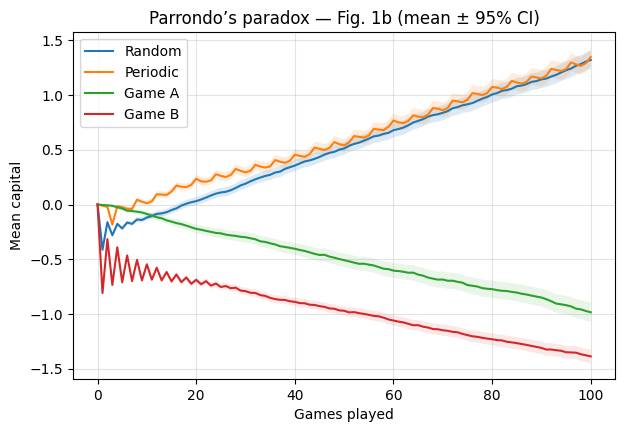

Estimated slopes (capital per game):
  Game A:    -0.0096  (theory ~ -0.0100)
  Game B:    -0.0089
  Periodic:   0.0142
  Random:     0.0159


In [ ]:
# Parameters of the paper
sample = 50_000
steps  = 100
budget0 = 0.0

# A parameters
pA1, epsA1 = 0.5, 0.005

# B parameters (classic)
M = 3
pB1, epsB1 = 0.1, 0.005
pB2, epsB2 = 0.75, 0.005

np.random.seed(2025) # reproducibility


# Game A only
_, mean_A, std_A = gameAB(budget=budget0, strategy="A", steps=steps, sample=sample,
                          pA1=pA1, epsA1=epsA1, M=M, pB1=pB1, epsB1=epsB1,
                          pB2=pB2, epsB2=epsB2, return_path=True)

# Game B only
_, mean_B, std_B = gameAB(budget=budget0, strategy="B", steps=steps, sample=sample,
                          pA1=pA1, epsA1=epsA1, M=M, pB1=pB1, epsB1=epsB1,
                          pB2=pB2, epsB2=epsB2, return_path=True)

# Strategy AABB
_, mean_periodic, std_periodic = gameAB(budget=budget0, strategy=("A","A","B","B"), steps=steps, sample=sample,
                                        pA1=pA1, epsA1=epsA1, M=M, pB1=pB1, epsB1=epsB1,
                                        pB2=pB2, epsB2=epsB2, return_path=True)

# Random Strategy
_, mean_random, std_random = gameAB(budget=budget0, strategy="random", steps=steps, sample=sample,
                                    pA1=pA1, epsA1=epsA1, M=M, pB1=pB1, epsB1=epsB1,
                                    pB2=pB2, epsB2=epsB2, return_path=True)

x = np.arange(steps+1)

# sem = std / sqrt(sample) for 95% CI of the mean
sem_A = std_A / np.sqrt(sample)
sem_B = std_B / np.sqrt(sample)
sem_periodic = std_periodic / np.sqrt(sample)
sem_random   = std_random / np.sqrt(sample)

plt.figure(figsize=(7,4.5))
plt.plot(x, mean_random,   label="Random")
plt.fill_between(x, mean_random-1.96*sem_random, mean_random+1.96*sem_random, alpha=0.15)

plt.plot(x, mean_periodic, label="Periodic")
plt.fill_between(x, mean_periodic-1.96*sem_periodic, mean_periodic+1.96*sem_periodic, alpha=0.15)

plt.plot(x, mean_A,        label="Game A")
plt.fill_between(x, mean_A-1.96*sem_A, mean_A+1.96*sem_A, alpha=0.10)

plt.plot(x, mean_B,        label="Game B")
plt.fill_between(x, mean_B-1.96*sem_B, mean_B+1.96*sem_B, alpha=0.10)

plt.xlabel("Games played")
plt.ylabel("Mean capital")
plt.title("Parrondo’s paradox — Fig. 1b (mean ± 95% CI)")
plt.grid(True, alpha=0.35)
plt.legend()
plt.show()

# slopes (linear ajust of the curves)
def slope(y):
    return np.polyfit(x, y, 1)[0]

print("Estimated slopes (capital per game):")
print(f"  Game A:    {slope(mean_A): .4f}  (theory ~ {-2*epsA1: .4f})")
print(f"  Game B:    {slope(mean_B): .4f}")
print(f"  Periodic:  {slope(mean_periodic): .4f}")
print(f"  Random:    {slope(mean_random): .4f}")



**Explanation of the Graphic:**
- Game A (Green line) and Game B (Red line) indivudually have negative drift (losing games)

- Periodic strategy (AABB) and Random mixing produce a positive drift (winning game)

- Rnadom switching yields a lightly larger slope than the strategy AABB, as it perturbs the residue distribution more strongly, keeping the chain away from the bad coin in game B

- The printed slipe for Game A, as we can see, is close to the theorical -2$ϵ$

**Intuitive visual for the winning strategy**

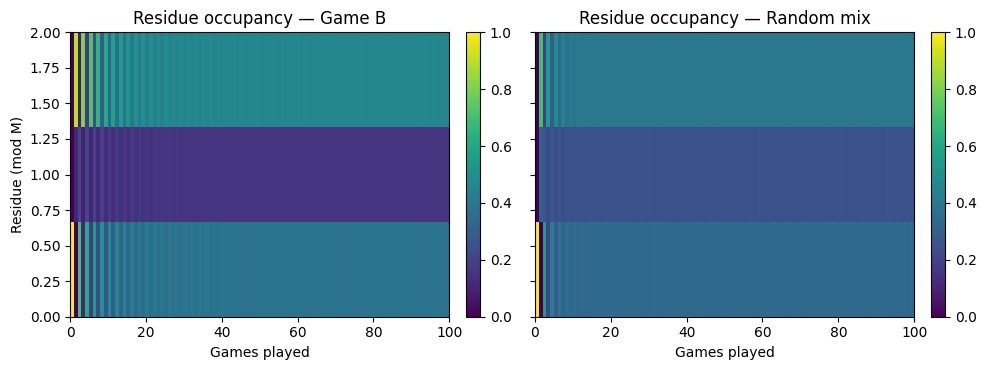

In [ ]:
# Shows how often each residue class (mod M) is visited over time.
# Compare B vs Random-A/B.

sample = 50_000
steps  = 100
budget0 = 0.0
M = 3
pA1, epsA1 = 0.5, 0.005
pB1, epsB1 = 0.1, 0.005
pB2, epsB2 = 0.75, 0.005

np.random.seed(999)

def residue_heatmap_data(strategy="B"):
    occ = np.zeros((steps+1, M), dtype=float)  # occ[t, r] = count at time t in residue r
    for _ in range(sample):
        capital = budget0
        occ[0, int(capital % M)] += 1
        for t in range(steps):
            if strategy == "B":
                capital = gameB(budget=capital, M=M, pB1=pB1, epsB1=epsB1, pB2=pB2, epsB2=epsB2)
            elif strategy == "RANDOM":
                g = "A" if (np.random.random()<0.5) else "B"
                if g=="A":
                    capital = gameA(budget=capital, pA1=pA1, eps=epsA1)
                else:
                    capital = gameB(budget=capital, M=M, pB1=pB1, epsB1=epsB1, pB2=pB2, epsB2=epsB2)
            else:
                raise ValueError("strategy must be 'B' or 'RANDOM'")
            occ[t+1, int(capital % M)] += 1
    return occ / sample  # convert to probabilities

occ_B  = residue_heatmap_data("B")
occ_R  = residue_heatmap_data("RANDOM")

fig, axs = plt.subplots(1,2, figsize=(10,3.8), sharey=True)
im0 = axs[0].imshow(occ_B.T, aspect='auto', origin='lower', extent=[0,steps, 0,M-1])
axs[0].set_title("Residue occupancy — Game B")
axs[0].set_xlabel("Games played"); axs[0].set_ylabel("Residue (mod M)")
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(occ_R.T, aspect='auto', origin='lower', extent=[0,steps, 0,M-1])
axs[1].set_title("Residue occupancy — Random mix")
axs[1].set_xlabel("Games played")
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


**Explanation of the Graphic:**

Why two losers make a winner.
Game A has constant negative drift -2ϵ. Game B is losing because its state-dependent rule yields a stationary distribution over residues that overuses the bad coin.

When mixing A and B—periodically or randomly—Game A's small “noise” reshuffles the residues, reducing the time in the "bad" residual, thus increasing the effective probability of winning. The coupling between state occupancy and coin choice causes the ensemble to win on average, even though A and B lose individually. Random switching tends to disrupt this occupancy more than AABB, generally generating a slightly larger slope.

**What the heatmaps show.**
Each column corresponds to time $t$ and displays the probability of being in residue $r = C_t \bmod M$. Rows (from bottom to top) represent residues $0,1,\dots,M-1$.

* **Game B:** The chain spends **more time** in the “bad” residue (for $M=3$, residue $0$), i.e., the state where Game B uses the bad coin. This asymmetric occupancy is exactly why Game B has a **negative drift** on average.


* **Random mix (A/B):** Random switching **reshuffles** the residues, flattening the occupancy and **reducing the time** spent in the bad residue. As a result, the effective average winning probability goes up and the global drift becomes **positive**—that is the operational core of Parrondo's paradox here.

**Transient vs. stationary behavior.**
Near $t=0$, the occupancy reflects the initial condition $C_0=0$ (all mass at residue $0$). As $t$ grows, the distribution approaches a (time-homogeneous) profile driven by the dynamics of the chosen strategy: concentrated on the bad residue for **B**, and much flatter for the **Random** mix.

**What we can conclude.**
Parrondo's paradox is not a logical contradiction; it's a **distribution-shaping effect**. Mixing A and B changes the **state occupancy**, decreasing visits to the bad residue and flipping the average drift from negative (losing) to positive (winning).

# Tarefa 4 - Parte 2

## Functions and Libraries

In [ ]:
#Libraries that will be used
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import imageio
import scipy.stats
import scipy.optimize
from scipy.interpolate import CubicSpline, interp1d
import numpy as np
from IPython.display import HTML
from google.colab import files
from IPython.display import Image
from math import comb
import pandas as pd

In [ ]:
# ============================
# Quantum Walk: Core Functions
# ============================

#1)-------------- Coin Builder ----------------
def coin_R(alpha_deg: float, beta_deg: float, gamma_deg: float) -> np.ndarray:
    """
    SU(2)-like coin operator used in the paper:
        R(alpha, beta, gamma) = [[ e^{iα} cosβ,   - e^{-iγ} sinβ ],
                      [ e^{iγ} sinβ,     e^{-iα} cosβ ]]

    Angles are given in degrees (converted to radians internally).

    Returns
    -------
    U : (2,2) complex ndarray
        Unitary coin matrix.
    """
    a = np.deg2rad(alpha_deg)
    b = np.deg2rad(beta_deg)
    g = np.deg2rad(gamma_deg)
    U = np.array([[np.exp(1j*a)*np.cos(b), -np.exp(-1j*g)*np.sin(b)],
                  [np.exp(1j*g)*np.sin(b),  np.exp(-1j*a)*np.cos(b)]],
                 dtype=np.complex128)
    return U


#2)-------------- Intial state Builder ----------------

def qw_init_state(steps: int,
                  coin_state: np.ndarray = None) -> tuple[np.ndarray, int]:
    """
    Build the initial state |Psi(0)> for a line of length L = 2*steps + 1.

    By default the coin is (|0> - i|1>)/sqrt(2) at position x=0, as in the paper.
    We represent the state as psi[coin, position], with coin ∈ {0,1} and
    positions indexed as i = 0..L-1 corresponding to x = i - center.

    Parameters
    ----------
    steps : int
        Number of walk steps you plan to run; sets the lattice size L=2*steps+1.
    coin_state : ndarray shape (2,), optional
        Initial coin spinor (normalized). If None -> (1, -i)/sqrt(2).

    Returns
    -------
    psi : ndarray, shape (2, L), complex128
        State vector in coin ⊗ position.
    center : int
        Index of the origin (x=0) in the position array.
    """
    L = 2*steps + 1
    center = steps
    psi = np.zeros((2, L), dtype=np.complex128)
    if coin_state is None:
        coin_state = np.array([1.0, -1.0j]) / np.sqrt(2.0)
    psi[:, center] = coin_state
    return psi, center

#3)-------------- Apply coin ----------------
def qw_apply_coin(psi: np.ndarray, U: np.ndarray) -> np.ndarray:
    """
    Apply the same coin U to every position (vectorized).

    psi'_{c,x} = sum_{c'} U_{c,c'} psi_{c',x}
    """
    # Equivalent to matrix-multiplying each column by U
    new0 = U[0,0]*psi[0] + U[0,1]*psi[1]
    new1 = U[1,0]*psi[0] + U[1,1]*psi[1]
    return np.vstack([new0, new1])


#4)-------------- Quantum shift (0 to left and 1 to right) ----------------
def qw_shift(psi_coin_applied: np.ndarray) -> np.ndarray:
    """
    Conditional shift:
        coin |0> moves LEFT  (x -> x+1),
        coin |1> moves RIGHT (x -> x-1).

    Edges are safe when lattice length L = 2*steps + 1 for exactly 'steps' moves.
    """
    _, L = psi_coin_applied.shape
    out = np.zeros_like(psi_coin_applied)

    # |0> -> right
    out[0, 1:L] += psi_coin_applied[0, 0:L-1]
    # |1> -> right
    out[1, 0:L-1]   += psi_coin_applied[1, 1:L]
    return out


#5)-------------- Quantum step ----------------
def qw_step(psi: np.ndarray, U: np.ndarray) -> np.ndarray:
    """
    One full DTQW step: apply coin U then conditional shift.
    """
    return qw_shift(qw_apply_coin(psi, U))


#6)-------------- position prob ----------------
def position_prob(psi: np.ndarray) -> np.ndarray:
    """
    Marginal position probability p_x = sum_c |psi_{c,x}|^2.
    """
    return (np.abs(psi[0])**2 + np.abs(psi[1])**2)

#7)-------------- Pr-Pl (for the article graphic) ----------------
def pr_minus_pl(psi: np.ndarray, center: int) -> float:
    """
    Compute PR - PL, excluding x=0 (i.e., center index).
    """
    p = position_prob(psi)
    PL = np.sum(p[:center])      # x < 0
    PR = np.sum(p[center+1:])    # x > 0
    return float(PR - PL)


In [ ]:
# =========================
# Quantum Parrondo "games"
# =========================

# Paper coin parameters (degrees):
RA_DEG = (137.2, 29.4, 52.1)
RB_DEG = (149.6, 67.4, 132.5)

def gameA_Q(steps: int = 10,
            RA_deg: tuple[float,float,float] = RA_DEG,
            init_coin: np.ndarray = None) -> np.ndarray:
    """
    Quantum Game A: use R_A at every step.
    Returns the array d[t] = PR(t) - PL(t) for t=0..steps.
    """
    U_A = coin_R(*RA_deg)
    psi, center = qw_init_state(steps, init_coin)
    d = np.zeros(steps+1, dtype=float)
    d[0] = pr_minus_pl(psi, center)
    for t in range(1, steps+1):
        psi = qw_step(psi, U_A)
        d[t] = pr_minus_pl(psi, center)
    return d

def gameB_Q(steps: int = 10,
            RB_deg: tuple[float,float,float] = RB_DEG,
            init_coin: np.ndarray = None) -> np.ndarray:
    """
    Quantum Game B: use R_B at every step.
    Returns d[t] = PR(t) - PL(t).
    """
    U_B = coin_R(*RB_deg)
    psi, center = qw_init_state(steps, init_coin)
    d = np.zeros(steps+1, dtype=float)
    d[0] = pr_minus_pl(psi, center)
    for t in range(1, steps+1):
        psi = qw_step(psi, U_B)
        d[t] = pr_minus_pl(psi, center)
    return d

def gameABB_Q(steps: int = 10,
              RA_deg: tuple[float,float,float] = RA_DEG,
              RB_deg: tuple[float,float,float] = RB_DEG,
              init_coin: np.ndarray = None) -> np.ndarray:
    """
    Quantum Game ABB (paper's convention for Fig. 3c):
    One *plotted* step = block of three micro-steps:
        S·R_A  ->  S·R_B  ->  S·R_B
    We record PR-PL only after completing each block.
    """
    U_A = coin_R(*RA_deg)
    U_B = coin_R(*RB_deg)

    micro_steps = 3*steps
    psi, center = qw_init_state(micro_steps, init_coin)
    d = np.zeros(steps+1, dtype=float)
    d[0] = pr_minus_pl(psi, center)
    for t in range(1, steps+1):
      psi = qw_step(psi, U_A)           # 1st micro-step in the block
      psi = qw_step(psi, U_B)           # 2nd
      psi = qw_step(psi, U_B)           # 3rd
      d[t] = pr_minus_pl(psi, center)   # sample only after the full ABB block
    return d

## Results and Exaplanations

> **Quantum Parrondo in a 1D Quantum Walk.**
> In a discrete time quantum walk, each step consists of a unitary coin flip $R(\alpha,\beta,\gamma)$ acting on the internal (coin) qubit, followed by a conditional shift on the line. The left–right imbalance
>
> $$
> P_R(t)-P_L(t)=\sum_{x>0}|\Psi(x,t)|^2 - \sum_{x<0}|\Psi(x,t)|^2
> $$
>
> quantifies the walker's directional bias.
> **Game A** (coin $R_A$) and **Game B** (coin $R_B$) individually produce small or negative bias in the short range, whereas the **periodic mixture ABB** generates a sustained **positive** bias even though neither A nor B alone is favorable. The “paradox” is not logical but dynamical: by alternating noncommuting unitaries, the interference pattern of probability amplitudes is reshaped, altering the populations and the phase relations that steer the wave packet. The ABB schedule amplifies constructive interference on the right and  destructive interference on the left, so $P_R-P_L$ remains positive over time. In other words, quantum superposition and interference play the role that “state reweighting” played in the classical case, now through phases and noncommuting operations rather than Markov occupancies.
---

Bellow are some figures and examples

**A) Reproduce Fig3.(a,b,c):$P_R-P_L$ vs number of steps**

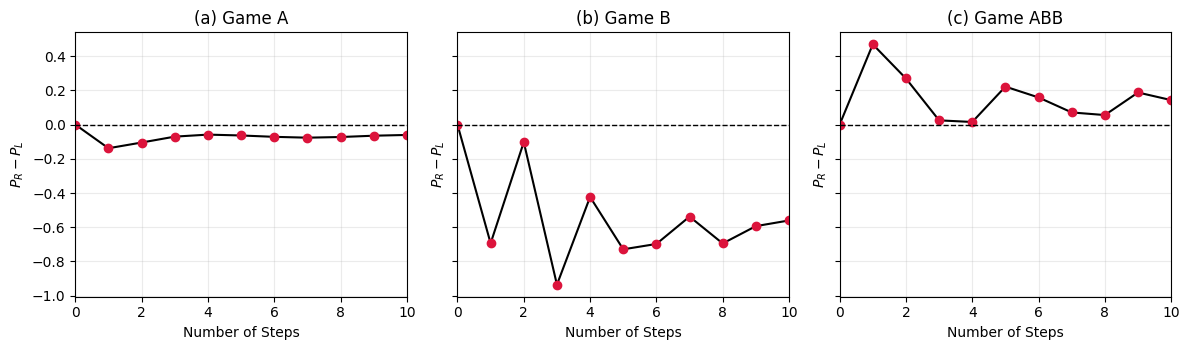

In [ ]:
# short-range like the figure (no inset)
steps = 10

# use the made functions (return d[t] for t=0..steps)
dA   = gameA_Q(steps=steps)       # panel (a)
dB   = gameB_Q(steps=steps)       # panel (b)
dABB = gameABB_Q(steps=steps)     # panel (c)

x = np.arange(steps+1)

def panel(ax, y, title):
    ax.plot(x, y, color="k", lw=1.5)
    ax.plot(x, y, "o", color="crimson", ms=6)
    ax.axhline(0.0, ls="--", color="k", lw=1)
    ax.set_xlim(0, steps)
    ax.set_xlabel("Number of Steps")
    ax.set_ylabel(r"$P_R - P_L$")
    ax.set_title(title)
    ax.grid(True, alpha=0.25)

fig, axs = plt.subplots(1, 3, figsize=(12, 3.6), sharey=True)
panel(axs[0], dA,   "(a) Game A")
panel(axs[1], dB,   "(b) Game B")
panel(axs[2], dABB, "(c) Game ABB")
plt.tight_layout()
plt.show()

**Explanation of the graphic:**
* **Game A (RA)** and **Game B (RB)** individually do **not** maintain a positive $P_R-P_L$ bias in the short range (their curves are below zero always).

* **Game ABB (RA→RB→RB)** exhibits a **persistent positive bias**: $P_R - P_L>0$ over steps, the quantum analogue of a “winning” trend.

* Physically, the paradox arises because alternating **non-commuting** coin unitaries reshapes interference: phases and amplitudes line up so that probability flows to the right more than to the left, even though neither RA nor RB alone creates a sustained right bias.


**B) Probability distributions at a fixed step (seeing $P_R-P_L$ directly)**

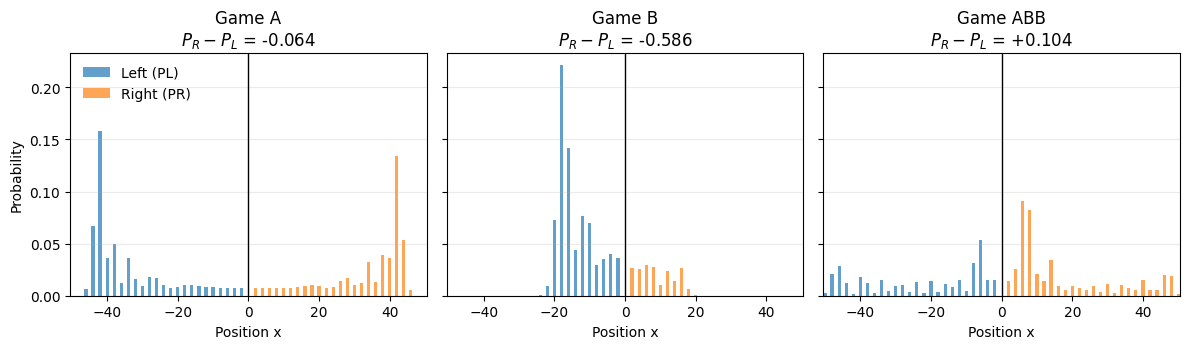

In [ ]:
# Choose a final time and plot the full position distributions for A, B, ABB
T = 50

# --- Game A ---
U_A = coin_R(*RA_DEG)
psiA, c0 = qw_init_state(T)
for _ in range(T):
    psiA = qw_step(psiA, U_A)
pA = position_prob(psiA)
xA = np.arange(-T, T+1)
PR_A = pA[c0+1:].sum(); PL_A = pA[:c0].sum(); dA_T = PR_A - PL_A

# --- Game B ---
U_B = coin_R(*RB_DEG)
psiB, c0 = qw_init_state(T)
for _ in range(T):
    psiB = qw_step(psiB, U_B)
pB = position_prob(psiB)
xB = np.arange(-T, T+1)
PR_B = pB[c0+1:].sum(); PL_B = pB[:c0].sum(); dB_T = PR_B - PL_B

# --- Game ABB ---
psiC, c0 = qw_init_state(T)
for t in range(1, T+1):
    psiC = qw_step(psiC, U_A)
    psiC = qw_step(psiC, U_B)
    psiC = qw_step(psiC, U_B)  # ABB periodic
pC = position_prob(psiC)
xC = np.arange(-T, T+1)
PR_C = pC[c0+1:].sum(); PL_C = pC[:c0].sum(); dC_T = PR_C - PL_C

fig, axs = plt.subplots(1, 3, figsize=(12, 3.6), sharey=True)

def bar_panel(ax, x, p, c0, title, dval):
    ax.bar(x[x<0], p[:c0], width=0.9, alpha=0.7, label="Left (PL)")
    ax.bar(x[x>0], p[c0+1:], width=0.9, alpha=0.7, label="Right (PR)")
    ax.axvline(0, color="k", lw=1)
    ax.set_xlim(-T-0.5, T+0.5)
    ax.set_xlabel("Position x")
    ax.set_title(f"{title}\n"+r"$P_R-P_L$"+f" = {dval:+.3f}")
    ax.grid(True, axis="y", alpha=0.25)

bar_panel(axs[0], xA, pA, c0, "Game A",   dA_T)
bar_panel(axs[1], xB, pB, c0, "Game B",   dB_T)
bar_panel(axs[2], xC, pC, c0, "Game ABB", dC_T)
axs[0].set_ylabel("Probability")
axs[0].legend(loc="upper left", frameon=False)
plt.tight_layout(); plt.show()


**Explanation of the Distributions:**
* The histograms show the full position probabilities at $t=T$.
* The **area to the right** (PR) minus the **area to the left** (PL), excluding $x=0$, equals the plotted value of $P_R-P_L$.
* You typically see $P_R-P_L\approx 0$ or negative for **A**/**B**, and **positive** for **ABB**, making the “win/lose/draw” condition visually explicit at the final time T.

**C) Order (non-commutativity) matters: Comparing ABB vs BBA vs ABA**

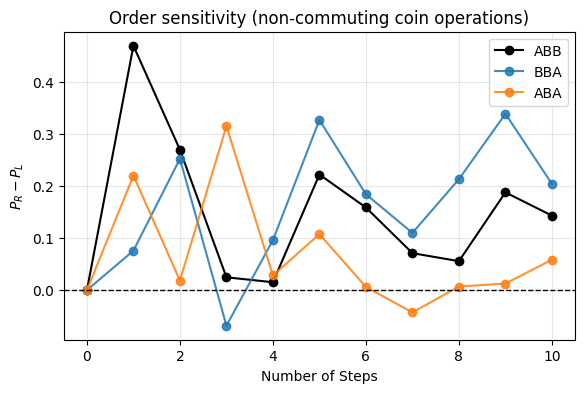

In [ ]:
def run_periodic_Q(steps,
                   seq,                      # e.g. ["A","B","B"]
                   RA_deg=RA_DEG, RB_deg=RB_DEG,
                   init_coin=None):
    U_A, U_B = coin_R(*RA_deg), coin_R(*RB_deg)
    block_len = len(seq)
    micro_steps = steps * block_len

    psi, c0 = qw_init_state(micro_steps, init_coin)
    d = np.zeros(steps + 1, dtype=float)
    d[0] = pr_minus_pl(psi, c0)

    for t in range(1, steps + 1):
        for s in seq:                         # run the whole block
            U = U_A if s.upper() == "A" else U_B
            psi = qw_step(psi, U)
        d[t] = pr_minus_pl(psi, c0)           # measure only after the block

    return d

# --- Order sensitivity plot (now sampling per block) ---
steps = 10
d_ABB = run_periodic_Q(steps, ["A","B","B"])   # matches your fixed gameABB_Q
d_BBA = run_periodic_Q(steps, ["B","B","A"])
d_ABA = run_periodic_Q(steps, ["A","B","A"])

x = np.arange(steps+1)
plt.figure(figsize=(6.6, 4))
plt.plot(x, d_ABB, "-o", label="ABB", color="k")
plt.plot(x, d_BBA, "-o", label="BBA", alpha=0.85)
plt.plot(x, d_ABA, "-o", label="ABA", alpha=0.85)
plt.axhline(0.0, ls="--", color="k", lw=1)
plt.xlabel("Number of Steps"); plt.ylabel(r"$P_R - P_L$")
plt.title("Order sensitivity (non-commuting coin operations)")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()



**Explanation of the Graphic:**

Because $R_A$ and $R_B$ **do not commute**, the schedule changes the interference landscape. Some orders (e.g., **ABB**) bias the walk to the right; others (e.g., **BBA**, **ABA**) can weaken that bias. This underlines that the quantum Parrondo effect is intrinsically tied to **unitary non-commutativity** and phase relations—unlike the classical case, where reweighting of residue classes did the trick.

---

**Physical interpretation of the saw classical and quantum "paradox"**

In the **classical** paradox, mixing changes the *state occupancy* (residue classes), reducing time spent in losing states.

In the **quantum** paradox, mixing **non-commuting** coins changes **interference**: phases and components are rotated so that constructive interference accumulates on the right (or destructive on the left). The net effect is a sustained positive $P_R-P_L$ for ABB even when A and B alone do not yield a right bias.

# Tarefa 4 - Parte 3 (Bonus - Entropia)  

**A) Classical entropy H(C_T)**

At each time t, estimate the **Shannon entropy** of the capital distribution

$$H(C_t)=-\sum_k P(C_t=k)logP(C_t=K)$$ acrross many trial

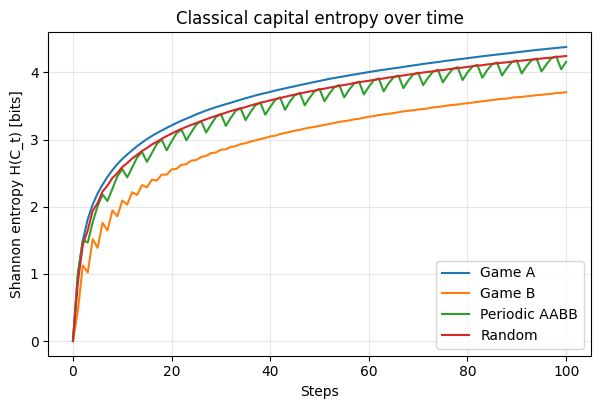

In [ ]:
# ---------- Parameters (match Part 1) ----------
sample = 50_000
steps  = 100
budget0 = 0

# Game A
pA1, epsA1 = 0.5, 0.005

# Game B
M = 3
pB1, epsB1 = 0.1, 0.005
pB2, epsB2 = 0.75, 0.005

np.random.seed(7)

def shannon_bits(p):
    m = p > 0
    return -np.sum(p[m] * np.log2(p[m]))

def classical_entropy(strategy=("A","A","B","B")):
    """
    Return H[t] for t=0..steps for a given strategy.
    strategy can be "A", "B", "random", or a sequence like ("A","A","B","B").
    Measurement is after each single step (as in Part 1).
    """
    # histogram counts: time x support ([-t,+t] -> index offset by +steps)
    counts = np.zeros((steps+1, 2*steps+1), dtype=np.int64)

    def pick_game(t):
        if isinstance(strategy, str):
            if strategy.lower() == "a":
                return "A"
            if strategy.lower() == "b":
                return "B"
            if strategy.lower() == "random":
                return "A" if (np.random.random() < 0.5) else "B"
            raise ValueError("Unknown string strategy.")
        # sequence / cycle
        return strategy[t % len(strategy)]

    for _ in range(sample):
        capital = budget0
        counts[0, steps + capital] += 1
        for t in range(1, steps+1):
            g = pick_game(t-1)
            if g == "A":
                capital = gameA(budget=capital, pA1=pA1, eps=epsA1)
            else:
                capital = gameB(budget=capital, M=M, pB1=pB1, epsB1=epsB1, pB2=pB2, epsB2=epsB2)
            counts[t, steps + capital] += 1

    # convert to probabilities per time step, compute entropy
    H = np.zeros(steps+1)
    for t in range(steps+1):
        support = slice(steps - t, steps + t + 1)  # only valid positions
        p = counts[t, support].astype(float) / sample
        H[t] = shannon_bits(p)
    return H

# compute entropies
H_A   = classical_entropy("A")
H_B   = classical_entropy("B")
H_ABB = classical_entropy(("A","A","B","B"))
H_RND = classical_entropy("random")


# --- Plot: raw entropy (bits) ---
x = np.arange(steps+1)
plt.figure(figsize=(7,4.2))
plt.plot(x, H_A,   label="Game A")
plt.plot(x, H_B,   label="Game B")
plt.plot(x, H_ABB, label="Periodic AABB")
plt.plot(x, H_RND, label="Random")
plt.xlabel("Steps"); plt.ylabel("Shannon entropy H(C_t) [bits]")
plt.title("Classical capital entropy over time")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()


**Explanation**

* $H(C_t)$ grows as the distribution spreads; bias (Game A) shifts the center but only mildly affects entropy.
* Game B's state-dependence and the mixes (AABB/Random) alter the *shape* of the distribution; random switching yields slightly higher entropy by “de-structuring” residue correlations.

**B) Quantum entropies: position vs coin-position entanglemen**

For each (A, B, ABB) we track two quantities per plotted step $t$:

1. **Position (measurement) entropy**
   $H_{\text{pos}}(t)=-\sum_x p_x(t)\log_2 p_x(t)$, with $p_x(t)=\sum_c |\psi_c(x,t)|^2$.

2. **Entanglement (von Neumann) entropy of the coin**
   $S_{\text{coin}}(t)=-\mathrm{Tr}\,\rho_c(t)\log_2\rho_c(t)$, where
   $\rho_c(t)=\sum_x |\psi(x,t)\rangle\langle\psi(x,t)|$ is the coin’s reduced state.

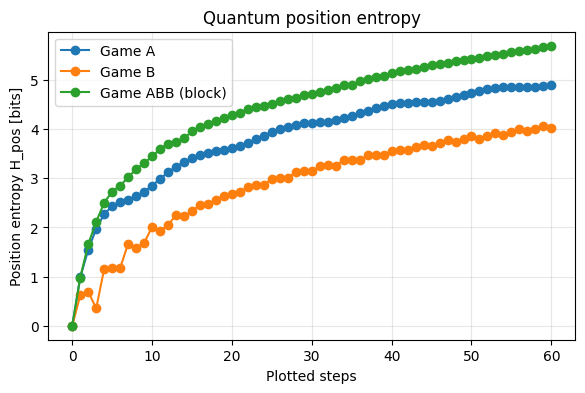

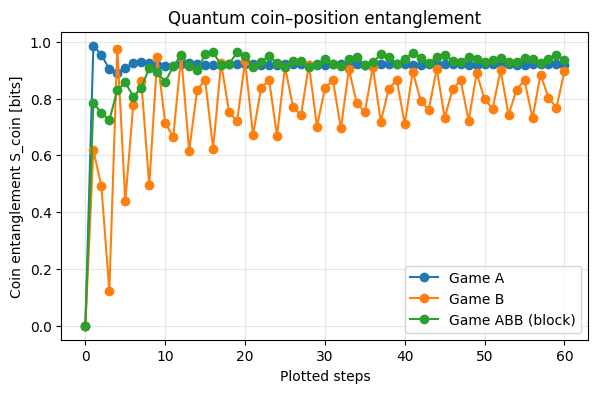

In [ ]:
def coin_entropy_and_position_entropy(game="A", steps=10,
                                      RA_deg=RA_DEG, RB_deg=RB_DEG):
    """
    Returns H_pos[t], S_coin[t] for t=0..steps.
    """
    U_A, U_B = coin_R(*RA_deg), coin_R(*RB_deg)

    # choose lattice to cover all micro-steps (ABB needs 3*steps)
    micro_steps = steps if game in ("A","B") else 3*steps
    psi, c0 = qw_init_state(micro_steps)

    H_pos  = np.zeros(steps+1)
    S_coin = np.zeros(steps+1)

    def vN_bits(rho):
        # hermitize (numerical safety), eigenvalues, Shannon in bits
        rhoH = 0.5*(rho + rho.conj().T)
        vals = np.linalg.eigvalsh(rhoH).real
        vals = np.clip(vals, 0.0, 1.0)
        m = vals > 0
        return -np.sum(vals[m]*np.log2(vals[m]))

    # t = 0
    p = position_prob(psi)
    H_pos[0] = shannon_bits(p)
    rho_c = np.array([[np.vdot(psi[0], psi[0]), np.vdot(psi[0], psi[1])],
                      [np.vdot(psi[1], psi[0]), np.vdot(psi[1], psi[1])]], dtype=np.complex128)
    rho_c /= np.trace(rho_c)
    S_coin[0] = vN_bits(rho_c)

    for t in range(1, steps+1):
        if game == "A":
            psi = qw_step(psi, U_A)
        elif game == "B":
            psi = qw_step(psi, U_B)
        else: # "ABB"
            psi = qw_step(psi, U_A)
            psi = qw_step(psi, U_B)
            psi = qw_step(psi, U_B)

        p = position_prob(psi)
        H_pos[t] = shannon_bits(p)

        rho_c = np.array([[np.vdot(psi[0], psi[0]), np.vdot(psi[0], psi[1])],
                          [np.vdot(psi[1], psi[0]), np.vdot(psi[1], psi[1])]], dtype=np.complex128)
        rho_c /= np.trace(rho_c)
        S_coin[t] = vN_bits(rho_c)

    return H_pos, S_coin

# compute
steps_q = 60
Hp_A,  Sc_A  = coin_entropy_and_position_entropy("A",   steps_q)
Hp_B,  Sc_B  = coin_entropy_and_position_entropy("B",   steps_q)
Hp_ABB,Sc_ABB= coin_entropy_and_position_entropy("ABB", steps_q)

# --- Plot: position entropy ---
x = np.arange(steps_q+1)
plt.figure(figsize=(6.8,4))
plt.plot(x, Hp_A,   "-o", label="Game A")
plt.plot(x, Hp_B,   "-o", label="Game B")
plt.plot(x, Hp_ABB, "-o", label="Game ABB (block)")
plt.xlabel("Plotted steps"); plt.ylabel("Position entropy H_pos [bits]")
plt.title("Quantum position entropy")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()

# --- Plot: coin entanglement entropy ---
plt.figure(figsize=(6.8,4))
plt.plot(x, Sc_A,   "-o", label="Game A")
plt.plot(x, Sc_B,   "-o", label="Game B")
plt.plot(x, Sc_ABB, "-o", label="Game ABB (block)")
plt.xlabel("Plotted steps"); plt.ylabel("Coin entanglement S_coin [bits]")
plt.title("Quantum coin–position entanglement")
plt.grid(True, alpha=0.3); plt.legend(); plt.show()


**Explanation:**

**What do the two entropies mean physically?**

* **Position (measurement) entropy $H_{\text{pos}}(t)$**
  The **classical Shannon entropy** of the **measured** position distribution $p(x,t)$. It quantifies how **spread out and structured** the *outcomes* are if you perform a position measurement at time $t$. It says nothing about quantum coherence directly; it's **basis- and measurement-dependent**.

* **Entanglement entropy $S_{\text{coin}}(t)$**
  This is the **von Neumann entropy** of the **reduced coin state** $\rho_c(t)$ (trace over positions). Because the global state $|\Psi(t)\rangle$ is **pure**, $S_{\text{coin}}(t)$ is exactly the **entropy of entanglement** between **coin** and **position** (range $0$ to $1$ bit for a qubit coin).

  • $S_{\text{coin}}\approx 0$: coin and position are nearly **separable** (little entanglement).

  • $S_{\text{coin}}\approx 1$: coin is nearly **maximally entangled** with position (locally it looks mixed).
---
**comparative (classical vs quantum)**

* Classical: entropy reflects stochastic mixing over paths; bias changes the mean but not the diffusion law. AABB/Random alter state occupancy correlations and can slightly increase entropy.

* Quantum: entropy reflects coherent interference and entanglement. Mixing non-commuting coins (ABB) changes phase relations, redistributing probability (position entropy) and typically sustaining a nonzero entanglement plateau (coin entropy).

The Parrondo effect appears as: classical, mixing changes state occupancy; quantum, mixing changes interference/entanglement.